In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import mean_squared_error
from scipy import signal



import sys

sys.path.append('../src')
from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os

from pydmd import DMD
import pickle

sys.path.append('../../disentangling-SDSC-fall-2020-master/external/disentangling-vae/')
import disvae
from disvae.utils.modelIO import load_model, load_metadata
from utils.datasets import get_dataset, get_dataloaders
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[autoreload of utils.datasets failed: Traceback (most recent call last):
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


# Loading, adding lags, normalizing and removing PCs

In [57]:
lags = 1
freq = 10
scale = 0.25
norm_scheme = 3

In [58]:
#******************************************************************************
# load data
#******************************************************************************
X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1900, end_year= 2010, tropical=0, scale=scale)

print(type(X))
#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Height
#******************************************************************************
X = add_channels(X)


# transfer to tensor
X = torch.from_numpy(X).float().contiguous()
print(X.min())
print(X.max())
print(X.mean())
print(X.std())
X_nolag = normalize(X,norm_scheme)

print(X_nolag.min())
print(X_nolag.max())
print(X_nolag.mean())
print(X_nolag.std())

# Add lags
X = add_lags(X_nolag, lags, freq=1)
print(X.shape)


<class 'numpy.ndarray'>
(4018, 18, 36)
<class 'numpy.ndarray'>
tensor(202.5253)
tensor(311.6788)
tensor(278.0957)
tensor(20.8426)
tensor(0.2500)
tensor(0.7500)
tensor(0.5269)
tensor(0.0471)
torch.Size([4018, 18, 36])


In [59]:
### Change number of lags (if needed)

lags = 30
X=add_lags(X_nolag, lags, freq=1)

In [60]:
X_f = X.reshape((X.shape[0],-1))
print(X_f.shape)

torch.Size([3989, 19440])


In [61]:
X_lags = X_f.reshape((X_f.shape[0],lags,int(72*scale),int(scale*144)))
if norm_scheme == 0:
    file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}.p"
elif norm_scheme == 1:
    file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_1dmean.p"
elif norm_scheme == 2:
    file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_1dminmax.p"
elif norm_scheme == 3:
    file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_2dminmax.p"
else:
    file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_2dminmax2.p"
with open( file_name, "wb" ) as f:
    pickle.dump( X_lags,f )

In [5]:
b = 16

In [6]:
pca = PCA(n_components=b)
pca.fit(X_f)
embeddings =pca.transform(X_f)

In [7]:
# remove the first b PCs from data and save

del(X)

b=2
X_red= np.dot(embeddings[:,:b],pca.components_[:b])
print(mean_squared_error(X_f,X_red))
X_noPC = (X_f-X_red).reshape((X_f.shape[0],-1, int(144*scale)))
X_firstlag=X_noPC[:,:int(72*scale)]
# renormalize
X_firstlag = normalize(X_firstlag,norm_scheme=2)
print(X_firstlag.shape)

del(X_red)



lags = 30
X_lags=add_lags(add_channels(X_firstlag), lags, freq=1)
print(X_lags.shape)
X_lags = X_lags.reshape((X_lags.shape[0],lags,int(72*scale),int(scale*144)))
print(X_lags.shape)

# save
file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_noPC{b}_new.p"
print(file_name)
with open( file_name, "wb" ) as f:
    pickle.dump( X_lags,f )

0.2766839882253283
torch.Size([2009, 18, 36])
torch.Size([1980, 540, 36])
torch.Size([1980, 30, 18, 36])
../../data/freq20_scale0.25_lags30_noPC2_new.p


## Remove all seasonalities extracted by b-VAE

In [43]:
latent = 2
# beta = 0.00001
# try beta = 0.001
# try beta = 0.01 extracts entangled features
# try beta = 0.05 **
beta = 1
alpha = 20
freq = 10
lags =3

# model_dir = f"../external/disentangling-vae/results/btcvae_sdsc-latent-{latent}"
model_dir = f"../../disentangling-SDSC-fall-2020-master/external/disentangling-vae/results/btcvae_sdsc-latent-{latent}-beta-{beta}"
# model_dir = f"../external/disentangling-vae/results/btcvae_sdsc-latent-{latent}-beta-0.0005"
# model_dir = f"../external/disentangling-vae/results/btcvae_sdsc-latent-{latent}-beta-{beta}-alpha-{alpha}"

[autoreload of utils.datasets failed: Traceback (most recent call last):
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/youssef/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


In [20]:
def get_model(model_dir: str) -> disvae.models.vae.VAE:
    model = load_model(model_dir)
    model.eval()
    return model

def get_dataloader(model_dir: str,
                   batch_size: int = 1024,
                   shuffle: bool = False) -> DataLoader:
    meta_data = load_metadata(model_dir)
    dataset = meta_data['dataset']
    return get_dataloaders(dataset, batch_size=batch_size, shuffle=shuffle)


In [44]:
model = get_model(model_dir)


In [45]:
dataloader = get_dataloader(model_dir)


In [46]:
x_seasonal = np.zeros((len(dataloader.dataset), lags, int(scale*72), int(scale*144)))
dx = np.zeros((len(dataloader.dataset), lags, int(scale*72), int(scale*144)))

batch_size = dataloader.batch_size

with torch.no_grad():
    for idx, (data, _) in enumerate(tqdm(dataloader)):
        x,_,_ = model(data)
        if idx == len(dataloader) - 1:
            x_seasonal[idx * batch_size:] = x#.cpu().numpy()
            dx[idx * batch_size:] = (data - x)#.cpu().numpy()
        else:
            x_seasonal[idx * batch_size:idx * batch_size + batch_size] = x#.cpu().numpy()
            dx[idx * batch_size:idx * batch_size + batch_size] = (data - x)#.cpu().numpy()

100%|██████████| 4/4 [00:00<00:00, 15.06it/s]


In [47]:
# renormalize
dx = torch.from_numpy(dx).float().contiguous()
dx =normalize(dx,norm_scheme=4)

print(dx.min())
print(dx.max())
print(dx.mean())
print(dx.std())

tensor(0.)
tensor(1.)
tensor(0.4532)
tensor(0.0550)


In [48]:
dx.shape

torch.Size([4016, 3, 18, 36])

In [35]:
lags=2
dx = dx[:,:lags,:,:]

In [49]:
# pickle dx

file_name = f"../../data/freq{freq}_scale{scale}_lags{lags}_noVAE_new.p"
print(file_name)
with open( file_name, "wb" ) as f:
    pickle.dump( dx,f )

../../data/freq10_scale0.25_lags3_noVAE_new.p


## FFT

In [52]:
harmonics = np.arange(30)

In [55]:
t= np.arange(len(X_f))

# STD comparison; before and after removing 2 PCs

In [13]:
import netCDF4
climate_file = netCDF4.Dataset('../../data/tas_ann_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')

lats = np.array(climate_file.variables['lat'])[::int(1/scale)]
lons = np.array(climate_file.variables['lon'])[::int(1/scale)]

In [14]:
# plot std before removing PCs
std= torch.std(X_nolag, dim=0)
plot_climate_data(temperature= np.array(std[0]) ,lats=lats, lons=lons, timestamp="hi", min_temp=-3, max_temp=3, savefile=False, filename=None)
del(X_nolag)

/home/youssef/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


0.22332881572941396
torch.Size([8011, 72, 144])
torch.Size([72, 144])
/home/youssef/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


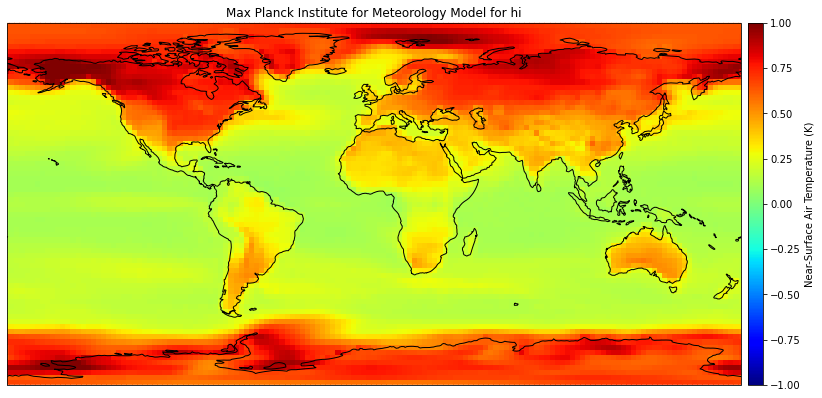

In [10]:
# plot std after removing PCs


std= torch.std(X_firstlag, dim=0)
print (std.shape)
plot_climate_data(temperature= np.array(std) ,lats=lats, lons=lons, timestamp="hi", min_temp=-3, max_temp=3, savefile=False, filename=None)
plot_climate_data(temperature= np.array(std) ,lats=lats, lons=lons, timestamp="hi", min_temp=-1, max_temp=1, savefile=False, filename=None)


In [11]:
print(X_firstlag.shape)
with open( f"../../data/noPC_5days_scale{scale}.p", "wb" ) as f:
    pickle.dump( X_firstlag,f )

torch.Size([8011, 72, 144])
